# Homework

---

### Q1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*

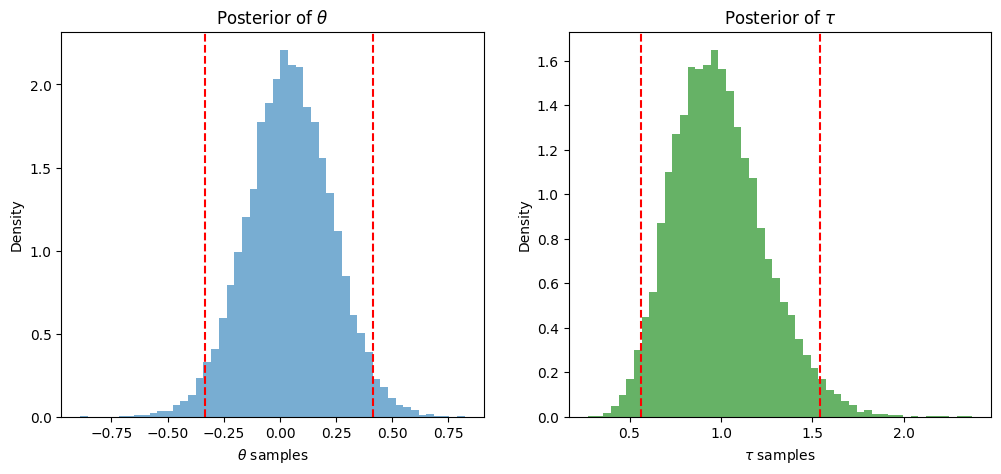

95% Credible Interval for θ: [-0.33293, 0.41217]
95% Credible Interval for τ: [0.56201, 1.54061]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma

def gibbs_sampler(n, m, s, num_iter=10000, burn_in=20, ci_level=0.95):
    x = stats.norm(loc=m, scale=s).rvs(size=n)
    C, G = 2, num_iter
    theta_samples, tau_samples = np.zeros([C, G]), np.zeros([C, G])
    theta_samples[:, 0] = np.mean(x)  # Start at observed mean
    tau_samples[:, 0] = 1

    for c in range(C):
        for g in range(1, G):
            # Sample tau | theta, x ~ Gamma(n/2 + 1, 1/(1/2 * sum (x_i - theta)^2))
            shape = n/2 + 1
            scale = 1/(0.5 * np.sum((x - theta_samples[c, g - 1]) ** 2)) if np.sum((x - theta_samples[c, g - 1]) ** 2) > 0 else 1e-6
            tau_samples[c, g] = gamma.rvs(a=shape, scale=scale)

            # Prevent division errors
            tau_safe = max(tau_samples[c, g], 1e-6)
            # Sample theta | tau, x ~ N(mean=x̄, variance=1 / (n * tau))
            theta_samples[c, g] = norm.rvs(loc=np.mean(x), scale=np.sqrt(1 / (n * tau_safe)))

    # remove samples from burn-in period
    theta_samples = theta_samples[:, burn_in:].flatten()
    tau_samples = tau_samples[:, burn_in:].flatten()

    # credible intervals
    alpha = (1 - ci_level) / 2
    theta_ci = np.percentile(theta_samples, [100 * alpha, 100 * (1 - alpha)])
    tau_ci = np.percentile(tau_samples, [100 * alpha, 100 * (1 - alpha)])

    return theta_samples, tau_samples, theta_ci, tau_ci

# example using in class example
theta_samples, tau_samples, theta_ci, tau_ci = gibbs_sampler(n=30, m=0, s=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_samples, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed')
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed')
ax[0].set_title(r"Posterior of $\theta$")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")

ax[1].hist(tau_samples, bins=50, density=True, alpha=0.6, color="green")
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed')
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed')
ax[1].set_title(r"Posterior of $\tau$")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")

plt.show()

print(f"95% Credible Interval for θ: [{theta_ci[0]:.5f}, {theta_ci[1]:.5f}]")
print(f"95% Credible Interval for τ: [{tau_ci[0]:.5f}, {tau_ci[1]:.5f}]")


### Q2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$.

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively.

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*



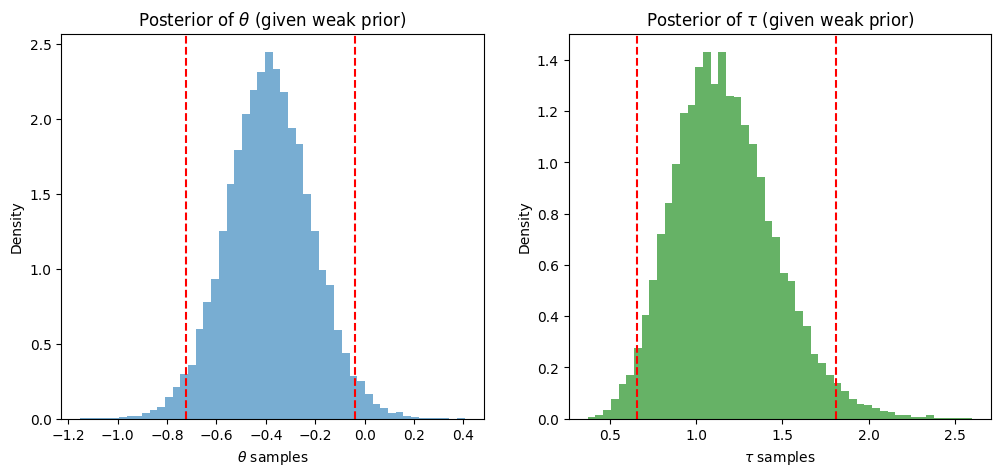

95% Credible Interval for θ (given weak prior): [-0.72180, -0.03964]
95% Credible Interval for τ (given weak prior): [0.65830, 1.81161]


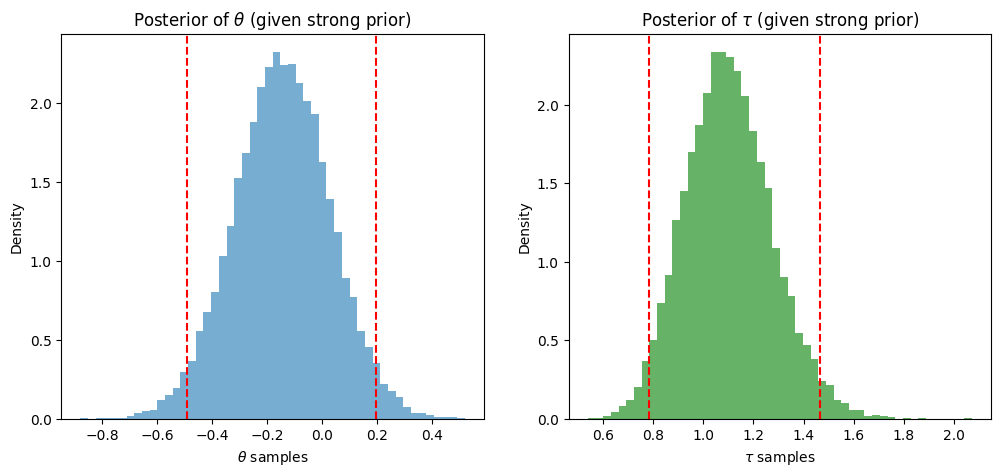

95% Credible Interval for θ (given strong prior): [-0.49297, 0.19632]
95% Credible Interval for τ (given strong prior): [0.78261, 1.46394]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma

np.random.seed(424)

def gibbs_sampler_updated(n, m, s, theta_0, tau_0, alpha, lambd, num_iter=10000, burn_in=20, ci_level=0.95):
    x = stats.norm(loc=m, scale=s).rvs(size=n)
    C, G = 2, num_iter
    theta_samples, tau_samples = np.zeros([C, G]), np.zeros([C, G])
    theta_samples[:, 0] = np.mean(x)
    tau_samples[:, 0] = 1

    for c in range(C):
        for g in range(1, G):
            # Update τ | θ, x ~ Gamma
            shape = (n + alpha) / 2
            scale = 1 / ((0.5 * np.sum((x - theta_samples[c, g - 1]) ** 2)) + (lambd / 2))
            tau_samples[c, g] = gamma.rvs(a=shape, scale=scale)

            # Update θ | τ, x ~ Normal
            theta_var = 1 / (n * tau_samples[c, g] + 1 / tau_0)
            theta_mean = theta_var * (n * tau_samples[c, g] * np.mean(x) + (theta_0 / tau_0))
            theta_samples[c, g] = norm.rvs(loc=theta_mean, scale=np.sqrt(theta_var))

    # remove samples from burn-in period
    theta_samples = theta_samples[:, burn_in:].flatten()
    tau_samples = tau_samples[:, burn_in:].flatten()

    # credible intervals
    alpha = (1 - ci_level) / 2
    theta_ci = np.percentile(theta_samples, [100 * alpha, 100 * (1 - alpha)])
    tau_ci = np.percentile(tau_samples, [100 * alpha, 100 * (1 - alpha)])

    return theta_samples, tau_samples, theta_ci, tau_ci

# Run the Gibbs sampler (weak prior)
theta_samples, tau_samples, theta_ci, tau_ci = gibbs_sampler_updated(n=30, m=0, s=1,
                                                             theta_0=0, tau_0=1, alpha=2, lambd=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_samples, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed')
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed')
ax[0].set_title(r"Posterior of $\theta$ (given weak prior)")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")

ax[1].hist(tau_samples, bins=50, density=True, alpha=0.6, color="green")
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed')
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed')
ax[1].set_title(r"Posterior of $\tau$ (given weak prior)")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")

plt.show()

print(f"95% Credible Interval for θ (given weak prior): [{theta_ci[0]:.5f}, {theta_ci[1]:.5f}]")
print(f"95% Credible Interval for τ (given weak prior): [{tau_ci[0]:.5f}, {tau_ci[1]:.5f}]")

# strong prior
theta_samples, tau_samples, theta_ci, tau_ci = gibbs_sampler_updated(n=30, m=0, s=1,
                                                             theta_0=-2, tau_0=5, alpha=50, lambd=50)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_samples, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed')
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed')
ax[0].set_title(r"Posterior of $\theta$ (given strong prior)")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")

ax[1].hist(tau_samples, bins=50, density=True, alpha=0.6, color="green")
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed')
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed')
ax[1].set_title(r"Posterior of $\tau$ (given strong prior)")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")

plt.show()

print(f"95% Credible Interval for θ (given strong prior): [{theta_ci[0]:.5f}, {theta_ci[1]:.5f}]")
print(f"95% Credible Interval for τ (given strong prior): [{tau_ci[0]:.5f}, {tau_ci[1]:.5f}]")

The strong prior affects the posterior distributions in the following ways:

- The 95% credible interval for θ is much tighter compared to the weak prior. This happens because the prior is contributing more "data points" to the posterior estimate, reducing the influence of the likelihood.

- The mean of θ has moved closer to the prior mean $θ_0$ with the strong prior, showing that the stronger prior has greater influence on the posterior estimate.

- The posterior distribution for τ is more concentrated (narrower spread), meaning we have less uncertainty about the precision. This happens because the strong prior for τ has a greater contribution (can be intuitively thought of as data points), stabilizing the estimate.



### Q3

*Read the following "conversation". My reactions to this initial text I was provied with are the colored font. Then either (A) provide an analagous derivation of this result for the multinomial-Dirichlet specification, or (B) just report that if the prior is a proper distribution then the posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and beside the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...*

Response to conversation:

If the prior is a proper probability distribution, then by Bayes' theorem we know the posterior is always proportional to the joint distribution, so it is easy to recognize its form/the type of distribution just by looking at the structure of the joint distribution. This means we don't actually need to compute the denominator in Bayes' theorem if we can just recognize the posterior distribution form from the joint. By following the rough proof reasoning, we can see that the denominator can be integrated out to the density, so we only really care about the shape (kernel) to find the family of the posterior.

In practice, Bayesians are not going to work with the exact functional form of the posterior. We instead want to generate histograms of data that we can work with and analyze, so we use sampling methods and tools like Markov Chain/Monte Carlo to generate samples from the posterior. From there we can use our histograms to produce credible intervals and probability statements to quantify our beliefs. By relying on what we know of proportionality, we can make things much easier for ourselves by quickly arriving at histograms after sampling from distributions based on their shape.